In [1]:
from torchvision import datasets
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import numpy as np
import torchvision.utils as vutils
import PIL.Image as Image
import matplotlib.pyplot as plt
torch.cuda.is_available()
from torchsummary import summary

In [2]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()
 
# Download the MNIST Dataset
dataset = datasets.MNIST(root = "./data",
                         train = True,
                         download = True,
                         transform = tensor_transform)
 
# DataLoader is used to load the dataset 
# for training
labels = [1, 2, 3, 4, 6, 7, 8, 9]
indices = [idx for idx, target in enumerate(dataset.targets) if target in labels]
loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, indices),
                                     batch_size = 32,
                                     shuffle = True)

In [3]:
len(loader)

1521

In [4]:
# Model structure
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # Encoder
        self.encoder = torch.nn.Sequential(
            nn.Linear(784, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 2),
            nn.Tanh()
        )
    def forward(self, inputs):
        codes = self.encoder(inputs)
        return codes
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )
    def forward(self, inputs):
        outputs = self.decoder(inputs)
        return outputs

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = Encoder()
        # Decoder
        self.decoder = Decoder()    
    def forward(self, inputs): # 修改縮排20241226
        codes = self.encoder(inputs)
        decoded = self.decoder(codes)
        return codes, decoded

In [5]:
epochs = 30
batch_size = 64
lr = 0.001
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

model_encoder = Encoder().to(device)
model_decoder = Decoder().to(device)

summary(model_encoder, (1, 784))
summary(model_decoder, (1, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              Tanh-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
              Tanh-4               [-1, 1, 128]               0
            Linear-5                [-1, 1, 64]           8,256
              Tanh-6                [-1, 1, 64]               0
            Linear-7                 [-1, 1, 2]             130
              Tanh-8                 [-1, 1, 2]               0
Total params: 242,242
Trainable params: 242,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.92
Estimated Total Size (MB): 0.93
----------------------------------------------------------------
------------------------------------------

In [7]:
optimizer_En = torch.optim.Adam(model_encoder.parameters(), lr=lr)
optimizer_De = torch.optim.Adam(model_decoder.parameters(), lr=lr)
loss_function = nn.MSELoss().to(device)# Train
model_encoder.train()
model_decoder.train()
log_loss=[]
for epoch in range(epochs):
    total_loss = 0
    for data, _ in loader:
        inputs = data.view(-1, 784).to(device) 
        
        model_encoder.zero_grad()
        model_decoder.zero_grad()
        
        codes = model_encoder(inputs)
        decoded = model_decoder(codes)
        loss = loss_function(decoded, inputs)
        loss.backward()
        
        optimizer_En.step()
        optimizer_De.step()
        
        total_loss+=loss
        log_loss.append(loss)
    total_loss /= len(loader.dataset)
    
    if epoch % 5 ==0:
        print('[{}/{}] Loss:'.format(epoch+1, epochs), total_loss.item())
print('[{}/{}] Loss:'.format(epoch+1, epochs), total_loss.item())

[1/30] Loss: 0.0013062169309705496
[6/30] Loss: 0.001128370058722794
[11/30] Loss: 0.001087098615244031
[16/30] Loss: 0.0010710093192756176
[21/30] Loss: 0.0010610026074573398
[26/30] Loss: 0.0010521792573854327
[30/30] Loss: 0.0010479384800419211


In [8]:
torch.save(model_encoder, 'mode_AutoEncoder_MNIST_Encoder3.pth')
torch.save(model_decoder, 'mode_AutoEncoder_MNIST_Decoder3.pth')

In [9]:
test_dataset = datasets.MNIST('./data', train=False, download=True, transform= transforms.ToTensor())

# Exclude Label 5 Test 
labels_t1 = [1, 2, 3, 4, 6, 7, 8, 9]
indices_t1 = [idx for idx, target in enumerate(test_dataset.targets) if target in labels_t1]
loader_t1 = torch.utils.data.DataLoader(torch.utils.data.Subset(test_dataset, indices_t1),
                                     batch_size = 1,
                                     shuffle = True)

# Label 5 
labels_t2 = [5]
indices_t2 = [idx for idx, target in enumerate(test_dataset.targets) if target in labels_t2]
loader_t2 = torch.utils.data.DataLoader(torch.utils.data.Subset(test_dataset, indices_t2),
                                     batch_size = 1,
                                     shuffle = True)

print(len(loader_t1))
print(len(loader_t2))

8128
892


In [10]:
def show_images(images):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28))
        plt.axis('off')# Load model

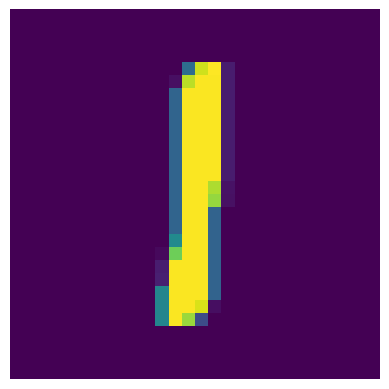

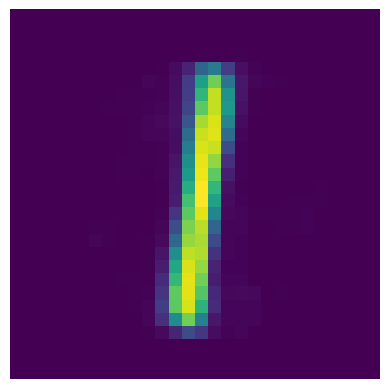

0.011102374643087387


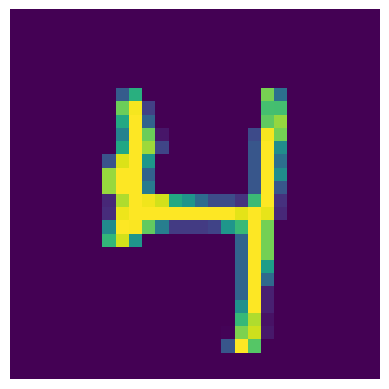

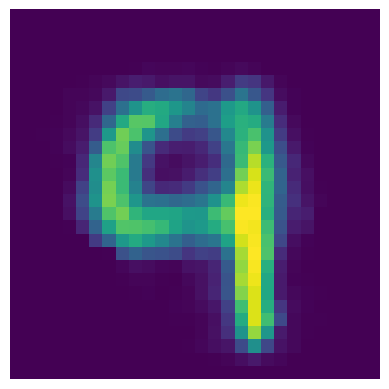

0.03788818046450615


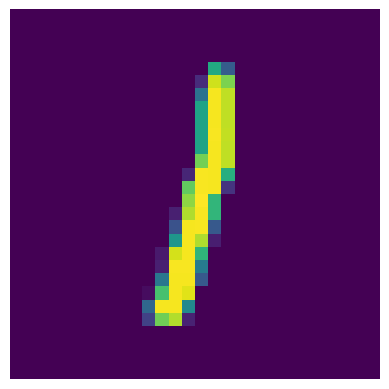

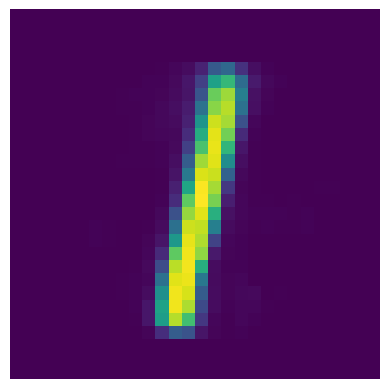

0.004120659548789263


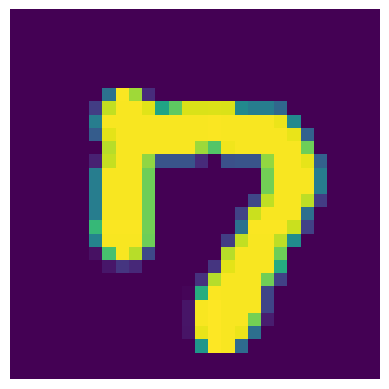

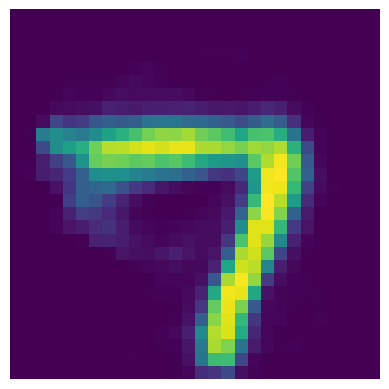

0.07120976597070694


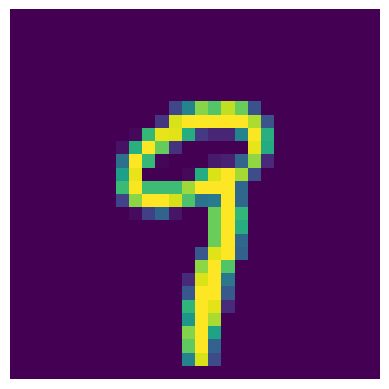

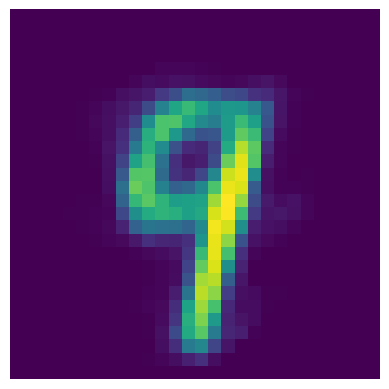

0.020571082830429077


In [11]:
criterion = nn.MSELoss(reduction='mean')
loss_dist = []
model_encoder.eval()
model_decoder.eval()
with torch.no_grad():
    for i, (data, target) in enumerate(loader_t1):
        inputs = data.view(-1, 28*28).to(device)
        # Forward
        model_encoder.zero_grad()
        model_decoder.zero_grad()
        
        codes = model_encoder(inputs)
        decoded = model_decoder(codes)

        show_images(inputs.detach().cpu())
        plt.show()# Forward

        show_images(decoded.detach().cpu())
        plt.show()# Forward
        
        
        loss = criterion(inputs.to(device), decoded)
        loss_dist.append(loss.item())

        print(loss.item())

        if i>3:
            break


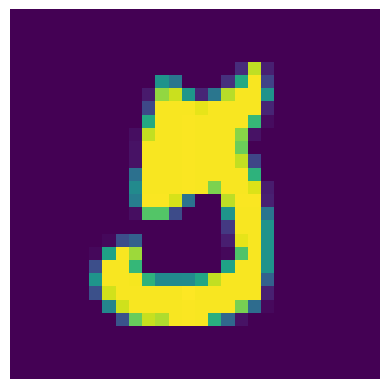

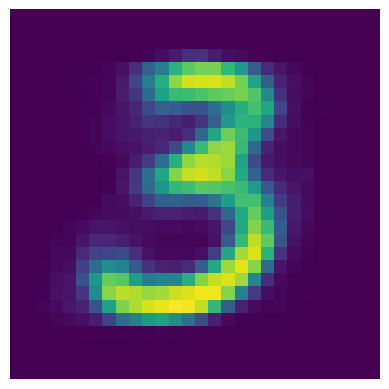

0.05032070353627205


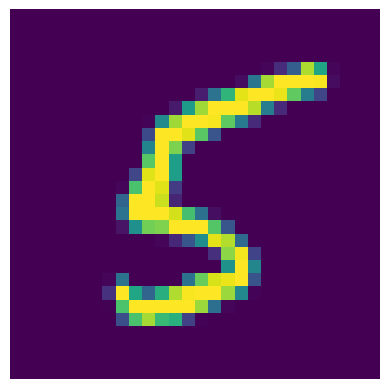

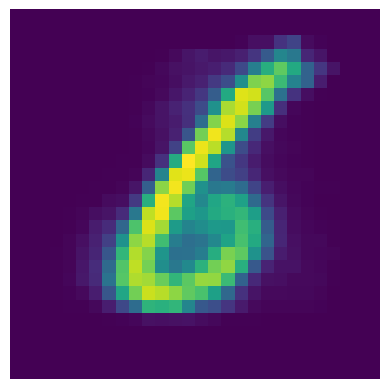

0.061038654297590256


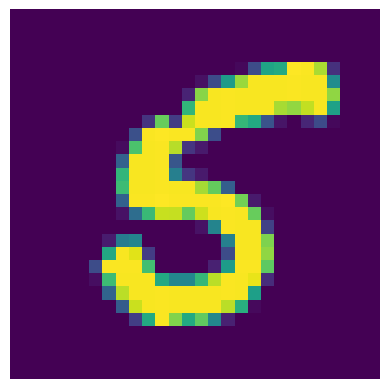

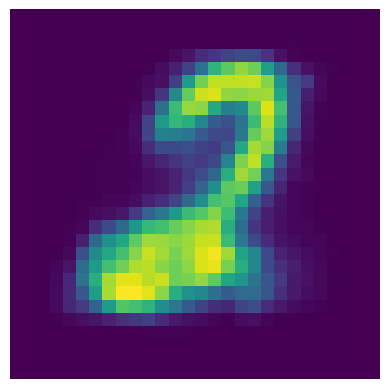

0.10100273042917252


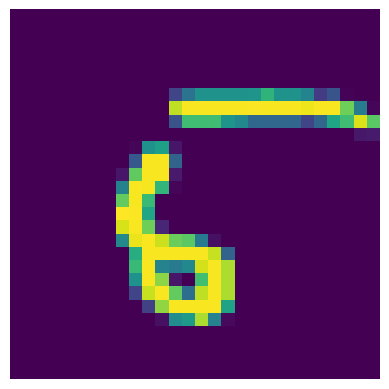

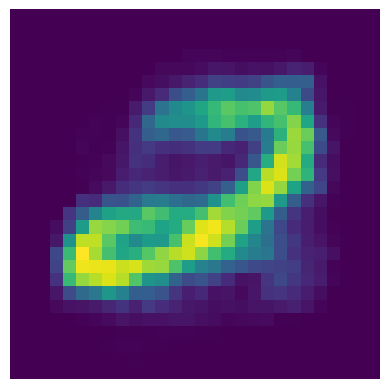

0.08844467252492905


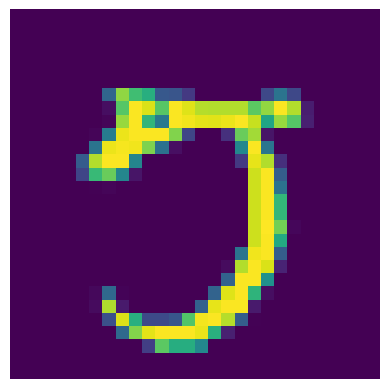

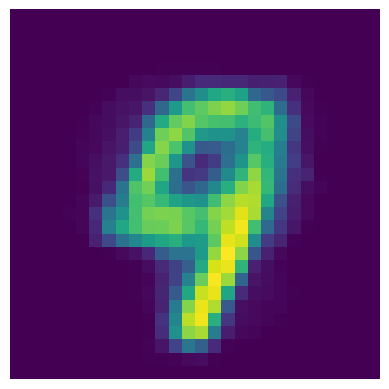

0.09248308092355728


In [12]:
criterion = nn.MSELoss(reduction='mean')
loss_dist = []
model_encoder.eval()
model_decoder.eval()
with torch.no_grad():
    for i, (data, target) in enumerate(loader_t2):
        inputs = data.view(-1, 28*28).to(device)
        # Forward
        model_encoder.zero_grad()
        model_decoder.zero_grad()
        
        codes = model_encoder(inputs)
        decoded = model_decoder(codes)

        show_images(inputs.detach().cpu())
        plt.show()# Forward

        show_images(decoded.detach().cpu())
        plt.show()# Forward
        
        
        loss = criterion(inputs.to(device), decoded)
        loss_dist.append(loss.item())

        print(loss.item())

        if i>3:
            break